In [1]:
import tensorflow as tf
import numpy as np
from random import randint
import matplotlib.pyplot as plt

import tensorflow_nn

%matplotlib inline

In [2]:
tf.reset_default_graph()

In [3]:
num_neurons = 125
iterations = 1000

### Defining connections

In [4]:
num_of_e_neurons = 100
num_of_i_neurons = 25

connections = []
connection_weights = []
for i in range(num_neurons):
    temp_conns = []
    temp_weights = []
    
    if i==100:
        temp_conns.append(0.)
        temp_weights.append(0.1)
        
#     if i < num_of_e_neurons:
#         count = 0
#         for j in range(num_of_e_neurons):
#             if i != j:
#                 number = randint(0, 99)
#                 if number < 100:
#                     temp_conns.append(j)
#                     count = count + 1
#         temp_weights.extend(np.random.normal(.1, .05, count).tolist())
        
#         count = 0
#         for j in range(num_of_e_neurons, num_of_e_neurons + num_of_i_neurons):
#             if i != j:
#                 number = randint(0, 99)
#                 if number < 10:
#                     temp_conns.append(j)
#                     count = count + 1
#         temp_weights.extend(np.random.normal(.1, .05, count).tolist())
#     else:
#         count = 0
#         for j in range(num_of_e_neurons):
#             if i != j:
#                 number = randint(0, 99)
#                 if number < 15:
#                     temp_conns.append(j)
#                     count = count + 1
#         temp_weights.extend(np.random.normal(.1, .05, count).tolist())

                
    connections.append(tf.Variable(np.asarray(temp_conns), dtype=tf.int32))
    connection_weights.append(tf.Variable(np.asarray(temp_weights), dtype=tf.float32))

### Defining initial state

In [5]:
inputs = tf.Variable(np.array([[0.]*(num_neurons)] * iterations))

ve_initial = tf.Variable(np.array([-40.]*num_of_e_neurons), dtype=tf.float32)

vi_initial = tf.Variable(np.array([-40.]*num_of_i_neurons), dtype=tf.float32)

ve_fired_initial = tf.zeros(num_of_e_neurons)
ve_fired_iteration = tf.zeros(num_of_e_neurons)

vi_fired_initial = tf.zeros(num_of_i_neurons)
vi_fired_iteration = tf.zeros(num_of_i_neurons)

initial_state = tensorflow_nn.BNNState(
    rk_variables=[[ve_initial], [vi_initial]],
    iteration=tf.Variable(0.), fired=[ve_fired_initial, vi_fired_initial],
    fired_iteration=[ve_fired_iteration, vi_fired_iteration])

### Defining custom current functions

In [6]:
def current_func(rk_variables, iteration, fired, fired_iteration, step_input, connections, connection_weights):
    [[ve], [vi]] = rk_variables
    [ve_fired, vi_fired] = fired
    [ve_fired_iter, vi_fired_iter] = fired_iteration
    
    #e type neurons
    ve_new = fIl_ve(ve)
    
    #i type neurons
    vi_new = fIl_vi(vi)
    
    #synapse calculation
    ## ...for loop for each type of connection and each type of input.....
    ve_syn, vi_syn = fIs(tf.concat([ve, vi], 0), iteration, tf.concat([ve_fired, vi_fired], 0),
                         tf.concat([ve_fired_iteration, vi_fired_iteration], 0),
                         connections, connection_weights)
    
    
    return [[tf.add(ve_new,ve_syn)], [tf.add(vi_new,vi_syn)]]


v_e = tf.Variable(np.random.normal(-65., 2, num_of_e_neurons), dtype=tf.float32)
gl_e = tf.Variable(np.random.normal(0.002, 0.0001, num_of_e_neurons), dtype=tf.float32)
dc_e_list = [0.] * num_of_e_neurons
dc_e_list[0] = 0.05
dc_e = tf.Variable(np.asarray(dc_e_list), dtype=tf.float32)

def fIl_ve(ve):
    ve_new = tf.add(tf.multiply(gl_e, tf.subtract(v_e, ve)), dc_e)
    return ve_new




v_i = tf.Variable(np.random.normal(-65., 2, num_of_i_neurons), dtype=tf.float32)
gl_i = tf.Variable(np.random.normal(0.002, 0.0001, num_of_i_neurons), dtype=tf.float32)

dc_i_list = [0.] * num_of_i_neurons
dc_i = tf.Variable(np.asarray(dc_i_list), dtype=tf.float32)

def fIl_vi(vi):
    vi_new = tf.add(tf.multiply(gl_i, tf.subtract(v_i, vi)), dc_i)
    return vi_new


tau = tf.constant(100.)
vs_ampa = tf.constant(0.) 
vs_gaba = tf.constant(-90.)

def fIs(v, iteration, fired, fired_iteration, connections, connection_weights):
    
    mul_product = []
    for i in range(num_neurons):
        #ampa synapses
        ampa_indices = tf.where(connections[i] < num_of_e_neurons)
        ampa_gather = tf.gather(tf.multiply(v, fired), tf.gather(connections[i], ampa_indices))
        ampa_weighted_gather = tf.multiply(tf.subtract(vs_ampa, ampa_gather),
                                           tf.gather(connection_weights[i], ampa_indices))

        #gaba synapses
        gaba_indices = tf.where(connections[i] >= num_of_e_neurons)
        gaba_gather = tf.gather(tf.multiply(v, fired), tf.gather(connections[i], gaba_indices))
        gaba_weighted_gather = tf.multiply(tf.subtract(vs_gaba, gaba_gather),
                                           tf.gather(connection_weights[i], gaba_indices))

        weighted_gather = tf.concat([ampa_weighted_gather, gaba_weighted_gather], 0)
        
        # what if f.exp(tf.divide(tf.subtract(iteration, fired_iteration), tau) -- is precalculated inside neuron calculation and passed to output neurons ?
        wg_mul_by_gs = tf.multiply(tf.exp(tf.divide(tf.subtract(iteration, fired_iteration), tau)), weighted_gather)

        mul_product.append(tf.reduce_sum(wg_mul_by_gs)) 

    syn_in = tf.stack(mul_product, 0)
    return tf.split(syn_in, [num_of_e_neurons, num_of_i_neurons], 0)

### Instantiate and run the simulation

In [7]:
bnn = tensorflow_nn.TFBNN(
    num_neurons=num_neurons, iterations=iterations, h=tf.constant(0.01), firing_threshold=tf.constant(-50.),
    firing_reset=tf.constant(-65.), current_func=current_func, initial_state=initial_state,
    inputs=inputs, connections=connections, connection_weights=connection_weights
)

In [8]:
%%time
output = bnn.run_simulation()

CPU times: user 21.9 s, sys: 25.8 s, total: 47.7 s
Wall time: 34.4 s


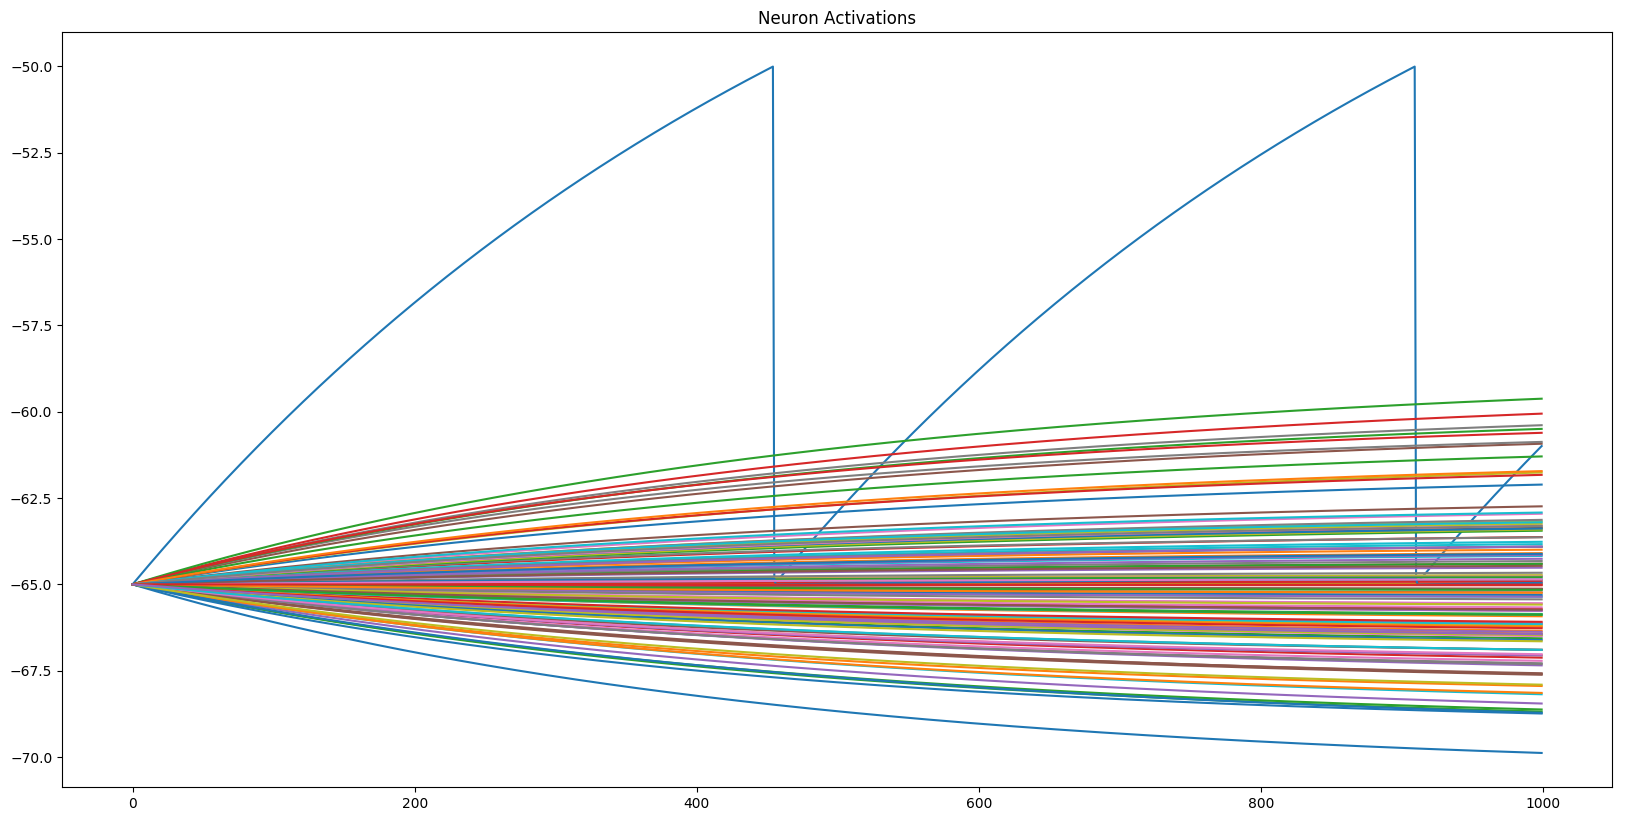

In [9]:
plt.figure(figsize=(20,10))
plt.title('Neuron Activations')

for i in range(num_of_e_neurons):
    plt.plot([y[i] for y in output[0][0][0]], label='v'+str(i+1))

for i in range(num_of_i_neurons):
    plt.plot([y[i] for y in output[0][1][0]], label='v'+str(i+100))

plt.show()